## Introduction to Ensembing/Stacking in python
- 필사 출처: https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

### Introduction
- This notebook is a very basic and simple introductory primer to the method of ensembling(combining) base learning models, in particular the variant of ensembling known as Stacking. in a nutshell stacking uses as a first-level(base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output form the earlier first-level predictions.
- The titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.
- I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here.
- Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner.

In [1]:
# load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

#going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

### Feature Exploration, Engineering and Cleaning
- Now we will proceed much like how most kernels in general are structed, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
#load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

#store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


- well it is no surprixe that our task is to somehow extract the information out of the categorical variables
#### Feature Engineering
- Here, credit must be extended to Sina's comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

In [3]:
full_data = [train,test]

#Gives the length of the name
train["Name_length"] = train["Name"].apply(len)
test["Name_length"] = test['Name'].apply(len)

#feature that tells whether a passenger had a cabin on the titanic
train["Has_Cabin"] = train["Cabin"].apply(lambda x:0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x:0 if type(x) == float else 1)

#feature engineering steps taken from Sina
#create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
  dataset["FamilySize"] = dataset['SibSp'] + dataset['Parch'] + 1

#create new feature IsAlone from FamilySize
for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

#remove all nulls in the embarked column
for dataset in full_data:
  dataset['Embarked'] = dataset["Embarked"].fillna('S')

#remove all nulls in the Fare column and create a new feature categoricalFare
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['categoricalFare'] = pd.qcut(train['Fare'],4)

#create a new feature categoricalAge
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'],5)

#Define function to extract titles from passenger names
def get_title(name):
  title_search = re.search('([A-Za-z]+)\.',name)
  #if the title exists, extract and return it
  if title_search:
    return title_search.group(1)
  return ""

#Create a new feature title, containing the titles of passenger names
for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)
#group all non-common titles into one single grouping "rare"
for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(["Lady","Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"],"Rare")

  dataset['Title'] = dataset['Title'].replace("Mlle","Miss")
  dataset['Title'] = dataset['Title'].replace('Ms',"Miss")
  dataset["Title"] = dataset["Title"].replace("Mme","Mrs")

for dataset in full_data:
  #mapping sex
  dataset["Sex"] = dataset['Sex'].map({"female":0,"male":1}).astype(int)

  #mapping titles
  title_mapping = {"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Rare":5}
  dataset["Title"] = dataset["Title"].map(title_mapping)
  dataset['Title'] = dataset["Title"].fillna(0)

  #mapping embarked
  dataset["Embarked"] = dataset["Embarked"].map({"S":0,"C":1,"Q":2}).astype(int)

  #mapping fare
  dataset.loc[dataset['Fare']<=7.91,'Fare'] = 0
  dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454),'Fare'] = 1
  dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31),'Fare'] = 2
  dataset.loc[dataset['Fare']>31,'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  #mapping age
  dataset.loc[dataset['Age']<=16,'Age'] = 0
  dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32),'Age'] = 1
  dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48),'Age'] = 2
  dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64),'Age'] = 3
  dataset.loc[dataset['Age']>64,'Age'] = 4

In [4]:
#feature selection
drop_elements = ['PassengerId',"Name","Ticket","Cabin","SibSp"]
train = train.drop(drop_elements,axis=1)
train = train.drop(['CategoricalAge'], axis = 1) #categoricalfare?
test = test.drop(drop_elements,axis=1)

- all right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be nurmeric, a format suitable to feed into our Machine learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe to.

#### Visualizations

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,categoricalFare,Title
0,0,3,1,1,0,0,0,23,0,2,0,"(-0.001, 7.91]",1
1,1,1,0,2,0,3,1,51,1,2,0,"(31.0, 512.329]",3
2,1,3,0,1,0,1,0,22,0,1,1,"(7.91, 14.454]",2


- Person Correlation Heatmap
  - let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
#ValueError: Cannot cast interval[float64, right] dtype to float64??

- Take away from the plots
  - one thing that the pearson correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch. i'll still leave both features in for the purposes of this exercise.

- Pairplots
  - finally let us generate some pairplots to obseerve the distribution of data from one feature to the other. Once again we use seaborn to help us.

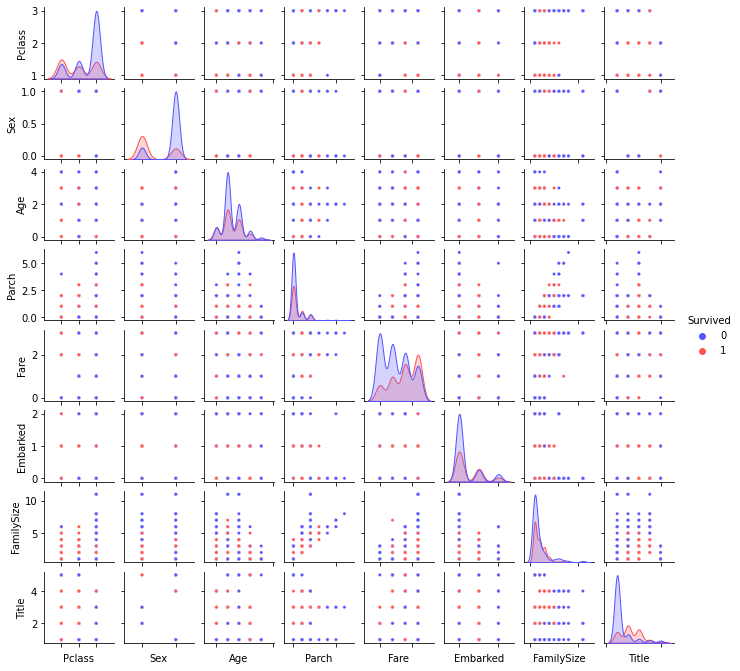

In [8]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

### Ensembling & Stacking models
- finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.
- Creating a stacking ensemble!

#### - Helpers via python classes
- here we invoke the use of python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears classes being used in conjuction with Object-Oriented Programming. in short, a class helps to extend some code/program for creating objects(variables for old-school peeps) as well as to implement functions and methods specific to that class.
- In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods(such as train, predict and fit) common to all the Sklearn classifiers. Therfore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [ ]:
#some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 #for reproducibility
NFOLDS = 5 #set folds for out-of-fold prediction
kf = KFold(ntrain, n_splits= NFOLDS, random_state=SEED)
#TypeError: __init__() got multiple values for argument 'n_splits'??

#class to extend the Sklearn classifier
class SklearnHelper(object):
  def __init__(self,clf,seed=0,params=None):
    params['random_state'] = seed
    self.clf = clf(**params)

  def train(self,x_train,y_train):
    self.clf.fit(x_train,y_train)

  def predict(self,x):
    return self.clf.predict(x)

  def fit(self,x,y):
    return self.clf.fit(x,y)

  def feature_importances(self,x,y):
    print(self.clf.fit(x,y).feature_importances_)

#class to extend XGboost classifier

- bear with me for those who already know this but for people who have not created classes or objects in python before, let me explain what the code given above does. in creating my base classifiers, i will only use the models already present in the Sklearn library and therefore only extend the class for that.
- def init: python standard for invoking the default constructor for the class. This means that when you want to create an object(classifier), you have to give it the parameters of clf(what sklearn classifier you want), random seed and params(parameters for the classifiers)
- The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.

#### - Out-of-Fold Predictions
- Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [ ]:
def get_oof(clf,x_train,y_train,x_test):
  oof_train = np.zeros((ntrain,))
  oof_test = np.zeros((ntest,))
  oof_test_skf = np.empty((NFOLDS,ntest))

  for i, (train_index,test_index) in enumerate(kf):
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[test_index]

    clf.train(x_tr,y_tr)

    oof_train[test_index] = clf.predict(x_te)
    oof_test_skf[i,:] = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0)
  return oof_train.reshape(-1,1),oof_test.reshape(-1,1)